# Import Library

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import matplotlib
import cv2 as cv
import numpy as np
import usrLibrary as lib
import tensorflow as tf
from tensorflow.python.client import device_lib

tf.__version__
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7391745485729531777
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 723714048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1338742518105371548
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0"
xla_global_id: 416903419
]


# Setting the Condition

In [2]:
class optical_condition:
    L:      float # distance from the sample plane to the detector plane
    p:      float # pixel size of the detector
    Npixel: int   # window size of the probe function, object functions, and diffraction patterns
    energy: float # x-ray energy of the incident beam
    h:      float # plank constant
    c:      float # velocity of the light
    lamb:   float # wavelength
    k:      float # wavenumber
    dx:     float # pixel resolution at the sample plane
    DR:     float # dynamic range of the detector, for example opt.DR = log10{1e7 (photons) / 1 (photon}
    Wnoise: bool  # flag to apply photon shot noise to each calculated diffraction pattern


opt         = optical_condition()

opt.L       = 3                                         # unit: m
opt.p       = 75e-6                                     # unit: m
opt.Npixel  = 1024                                      # unit: pixel
opt.energy  = 5000                                      # unit: eV (electronVolt)
opt.h       = 6.62607015e-34                            # unit: m^2 kg/s
opt.c       = 299792458                                 # unit: m/s
opt.lamb    = (opt.h * 6.242e18) * opt.c / opt.energy   # unit: m
opt.k       = 2 * np.pi / opt.lamb                      # unit: 1/m
opt.dx      = opt.L * opt.lamb / (opt.Npixel * opt.p)   # unit: m/pixel
opt.DR      = 7
opt.Wnoise  = True

In [3]:
class aperture_condition:
    sideNumber:         int     # number of the side
    sideLength:         float   # length of a side
    Lpropagation:       float   # distance from the aperture to the sample
    needPropagation:    bool    # flag whether propagation from the aperture to the sample is needed

aper = aperture_condition()

aper.sideNumber     = 3     # input: 3 --> Triangle
aper.sideLength     = 5e-6  # unit: m
aper.Lpropagation   = 5e-4     # unit: m, range: # 500-1000*10^-6

if aper.Lpropagation > 0:
    aper.needPropagation = True
else:
    aper.needPropagation = False

In [4]:
class particle_condition:
    beta_Au:    float # parameter related to the absorption of the wavefield
    delta_Au:   float # parameter related to the phase shift of the wavefield
    diameter:   float # diameter of the gold nanoparticle
    ratio:      float # (Area occupied with gold nanoparticles) / (Area of the window, Npixel x Npixel)
    number:     int   # total number of the gold nanoparticles within the window
    velocity:   float # displacement of the gold nanoparticles (per frame)

par = particle_condition()

par.beta_Au     = 2.633e-5
par.delta_Au    = 1.2143e-4
par.diameter    = 150e-9 #300e-9 # unit: m
par.ratio       = 100e-3
par.number      = int(np.floor((opt.Npixel * opt.dx)**2 / (np.pi * (par.diameter / 2)**2) * par.ratio))
par.Nframe      = 11
par.velocity    = 1 * opt.dx    # unit: m/frame

In [5]:
print(opt.dx)

9.687027375252824e-09


# Function Calculation

In [6]:
# set different seed per n frame
tf.random.set_seed(1)

aperture = lib.calcAperture(opt, aper)
smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
if aper.needPropagation == 1:
    inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
else:
    inwave = aperture

AuNPimg = lib.calcAuNP(opt, par)

wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

difImg       = np.abs(wavedetector)**2

# diffraction patterns are normalized so that its dynamic range become "opt.DR"
maxCount     = difImg.max()
difImg       = difImg / maxCount * 10**(opt.DR)
isCounted    = np.where(difImg >= 1, 1, 0)
difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

# 2-4-3, apply photon shot noise if "opt.Wnoise" is True
if opt.Wnoise == 1:
    difImgWnoise = np.random.poisson(difImg)

0
1
2
3
4
5
6
7
8
9
10


# Output Image from Simulator

## Absolute

### Without the Aperture

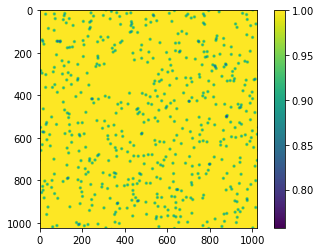

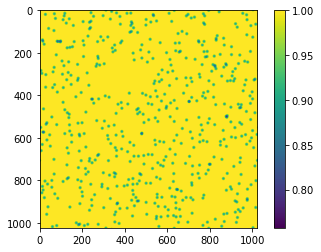

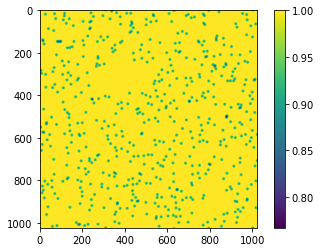

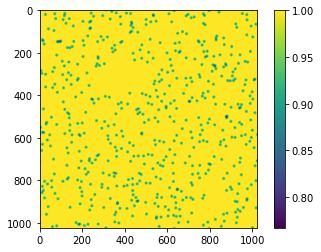

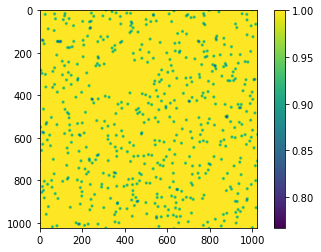

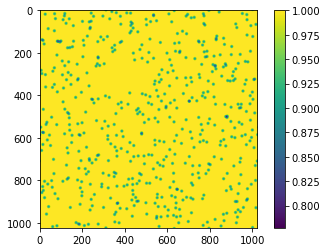

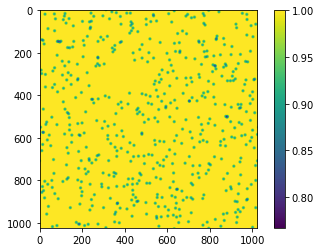

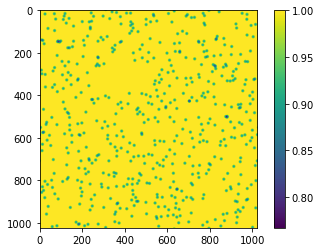

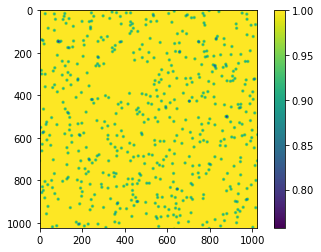

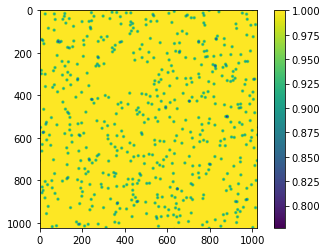

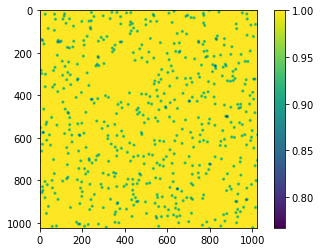

In [8]:
for i in range(par.Nframe):
    plt.imshow(np.abs(AuNPimg[:, :, i]))
    plt.colorbar()
    plt.show()

### With the Aperture

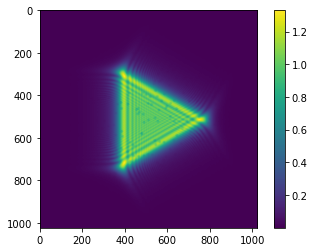

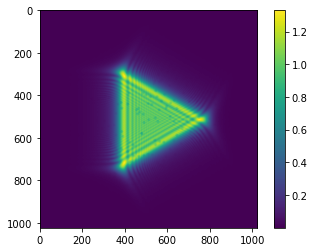

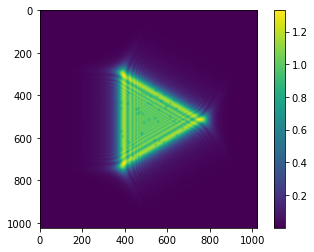

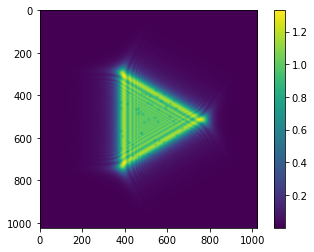

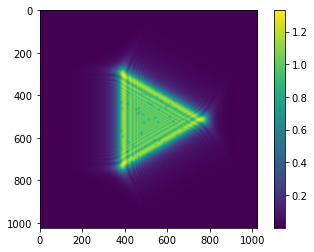

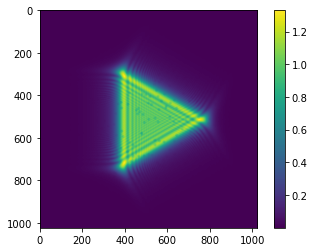

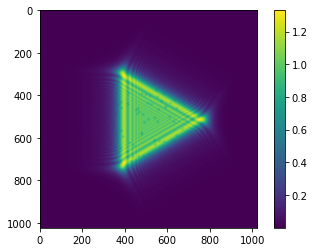

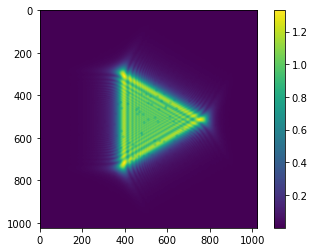

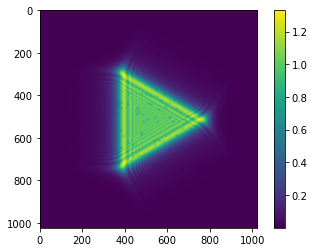

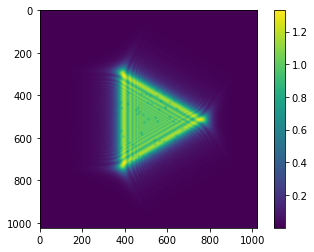

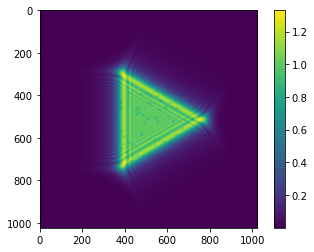

In [9]:
for i in range(par.Nframe):
    plt.imshow(np.abs(AuNPimg[:, :, i]*inwave))
    plt.colorbar()
    plt.show()

## Angle

### Without Aperture

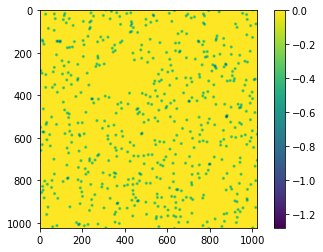

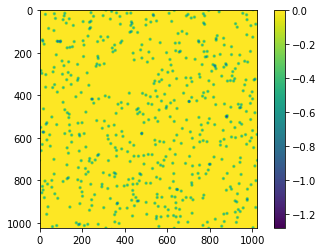

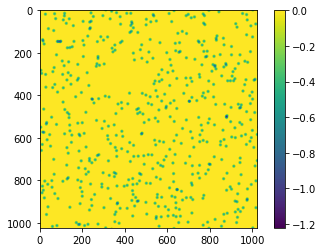

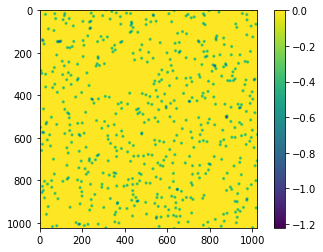

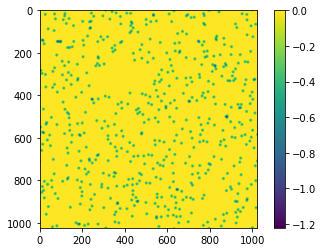

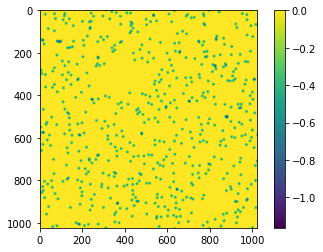

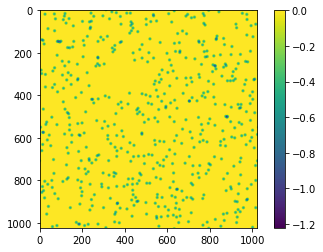

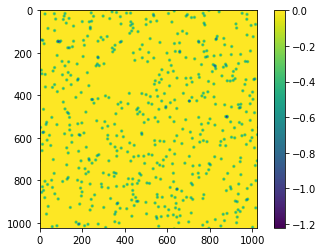

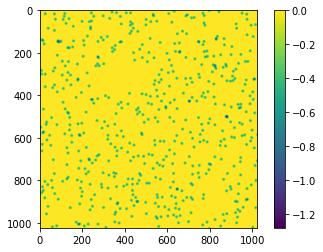

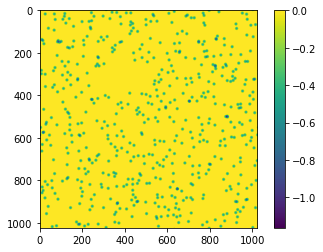

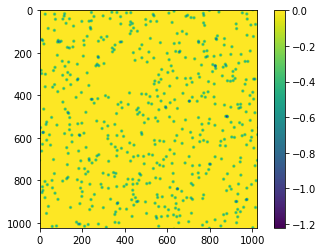

In [10]:
for i in range(par.Nframe):
    plt.imshow(np.angle(AuNPimg[:, :, i]))
    plt.colorbar()
    plt.show()

### With Aperture

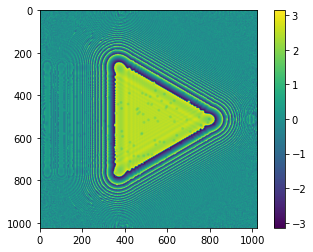

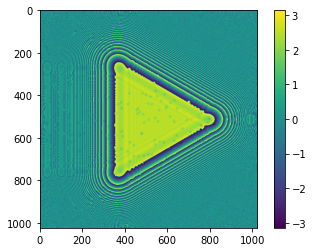

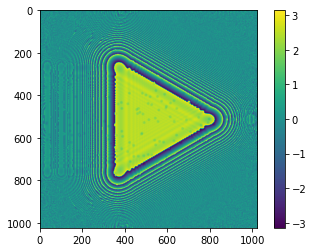

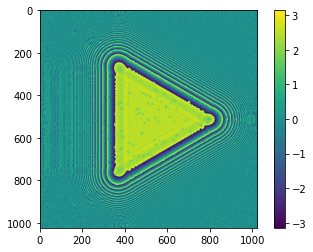

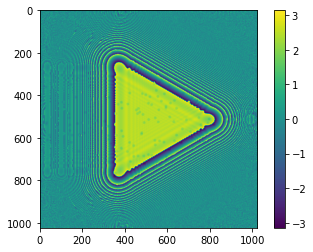

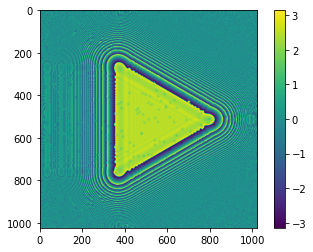

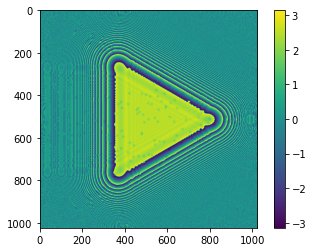

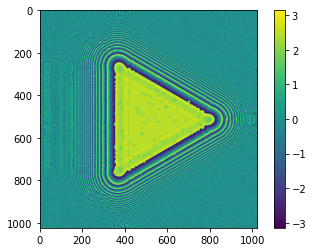

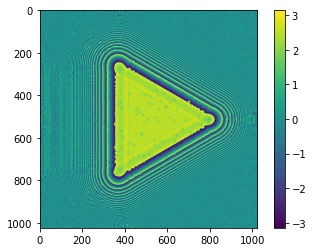

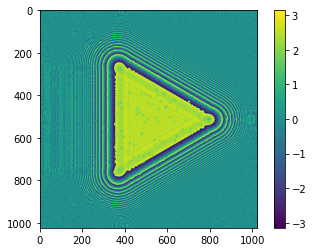

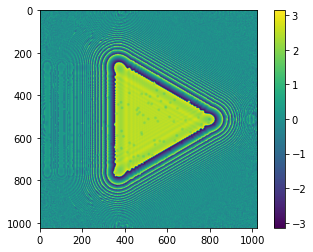

In [11]:
for i in range(par.Nframe):
    plt.imshow(np.angle(AuNPimg[:, :, i]*inwave))
    plt.colorbar()
    plt.show()

# Combined 11 Frames

In [12]:
frame_sum = np.sum(AuNPimg,-1,keepdims=True)

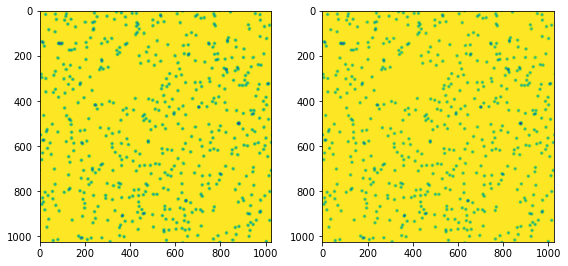

In [13]:
fig = plt.figure(figsize = [8, 8])

ax = plt.subplot(1,2,1)
im = plt.imshow(np.abs(frame_sum))

ax2 = plt.subplot(1,2,2)
im = plt.imshow(np.angle(frame_sum))

plt.tight_layout()
plt.show()

## Combined Diffraction Image

In [14]:
wavesample_sum = np.sum(difImg,-1,keepdims=True)

### Absolute

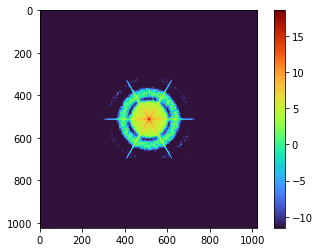

In [15]:
plt.imshow(np.log(np.abs(wavesample_sum+1e-5)), cmap="turbo")
plt.colorbar()
plt.show()

# Generate the Data (One Run)

1. abs(frame0)
2. abs(frame5)
3. angle(sumof11frames)
4. angle(frame0)
5. abs(frame5)
6. angle(sumof11frames)
7. abs(wavesample_sum)


In [30]:
print(np.array(abs(AuNPimg[:,:,0])).shape)
print(np.array(abs(AuNPimg[:,:,5])).shape)
print(abs(frame_sum).shape)
print(np.array(np.angle(AuNPimg[:,:,0])).shape)
print(np.array(np.angle(AuNPimg[:,:,1])).shape)
print(np.angle(frame_sum).shape)
print(np.array(np.abs(wavesample_sum)).shape)
print(np.array(np.angle(wavesample_sum)).shape)
print(difImgWnoise.shape)

(1024, 1024)
(1024, 1024)
(1024, 1024, 1)
(1024, 1024)
(1024, 1024)
(1024, 1024, 1)
(1024, 1024, 1)
(1024, 1024, 1)
(1024, 1024, 1)


In [31]:
arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).reshape((1024,1024)),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).reshape((1024,1024)),
                      np.abs(wavesample_sum).reshape((1024,1024))
                    ))

arr_stack.shape

(9, 1024, 1024)

**Note:**

Alternatively, ``np.squeeze()`` can be used to remove dimension with 1 value

In [32]:
arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).squeeze(),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).squeeze(),
                      np.abs(wavesample_sum).squeeze()
                    ))

arr_stack.shape

(9, 1024, 1024)

# Save the Array into Numpy File

## Using npy

In [33]:
np.save('data/test1', arr_stack)

## Using npz

In [66]:
np.savez('data/test1',arr_stack)

## Using npz Compressed

(9, 1024, 1024)


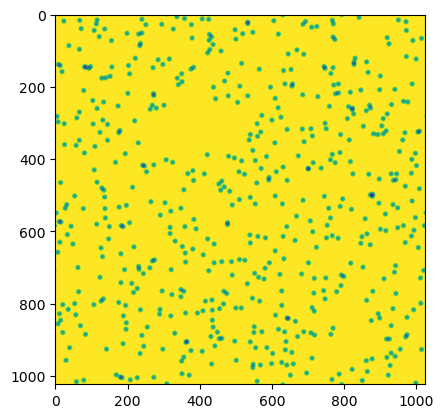

In [72]:
np.savez_compressed('data/test1compressed', arr_stack = arr_stack)
file_content = np.load('data/test1compressed.npz', allow_pickle=True)
print(file_content['arr_stack'].shape)

# Generator using Looping

In [25]:
def generate_ptycho_array(num_loop):
    # set different seed per n frame
    np.random.seed(num_loop)

    aperture = lib.calcAperture(opt, aper)
    smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
    if aper.needPropagation == 1:
        inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
    else:
        inwave = aperture

    AuNPimg = lib.calcAuNP(opt, par)

    wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
    wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

    difImg       = np.abs(wavedetector)**2

    # diffraction patterns are normalized so that its dynamic range become "opt.DR"
    maxCount     = difImg.max()
    difImg       = difImg / maxCount * 10**(opt.DR)
    isCounted    = np.where(difImg >= 1, 1, 0)
    difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

    # 2-4-3, apply photon shot noise if "opt.Wnoise" is True
    if opt.Wnoise == 1:
        difImgWnoise = np.random.poisson(difImg)

    frame_sum = np.sum(AuNPimg,-1,keepdims=True)
    wavesample_sum = np.sum(difImg,-1,keepdims=True)
    
    arr_stack = np.stack((np.array(np.abs(AuNPimg[:,:,0])),
                      np.array(np.abs(AuNPimg[:,:,5])),
                      np.abs(frame_sum).squeeze(),
                      np.array(np.angle(AuNPimg[:,:,0])),
                      np.array(np.angle(AuNPimg[:,:,5])),
                      np.angle(frame_sum).squeeze(),
                      np.abs(wavesample_sum).squeeze()
                    ))
    
    return arr_stack

In [29]:
def generate_ptycho_array(num_loop):
    # set different seed per n frame
    np.random.seed(num_loop)

    aperture = lib.calcAperture(opt, aper)
    smooth_aperture = cv.GaussianBlur(aperture, (9,9), 0)
    if aper.needPropagation == 1:
        inwave = lib.angularSpectrum(smooth_aperture, opt, aper)
    else:
        inwave = aperture

    AuNPimg = lib.calcAuNP(opt, par)

    wavesample = AuNPimg * np.tile(inwave[:, :, np.newaxis], (1, 1, par.Nframe))
    wavedetector = np.fft.fftshift(np.fft.fft2(wavesample, axes = (0, 1)), axes = (0, 1))

    difImg       = np.abs(wavedetector)**2

    # diffraction patterns are normalized so that its dynamic range become "opt.DR"
    maxCount     = difImg.max()
    difImg       = difImg / maxCount * 10**(opt.DR)
    isCounted    = np.where(difImg >= 1, 1, 0)
    difImg       = difImg * isCounted # pixels which count lower than 1 photon is set to 0

    # 2-4-3, apply photon shot noise if "opt.Wnoise" is True
    if opt.Wnoise == 1:
        difImgWnoise = np.random.poisson(difImg)

    frame_sum = tf.reduce_sum(AuNPimg, axis=-1, keepdims=True)
    wavesample_sum = tf.reduce_sum(difImg, axis=-1, keepdims=True)

    arr_stack = tf.stack([
        tf.abs(AuNPimg[:, :, 0]),
        tf.abs(AuNPimg[:, :, 5]),
        tf.squeeze(tf.abs(frame_sum)),
        tf.angle(AuNPimg[:, :, 0]),
        tf.angle(AuNPimg[:, :, 5]),
        tf.squeeze(tf.angle(frame_sum)),
        tf.squeeze(tf.abs(wavesample_sum))
    ], axis=0)

    return arr_stack

In [30]:
with tf.device("/device:GPU:0"):
    for i in range(1000):
        filename = 'data/ptychoAUNP_'+str(i)
        np.savez_compressed(filename,arr_stack=generate_ptycho_array(i))

0
1
2
3
4
5
6
7
8
9
10


AttributeError: module 'tensorflow' has no attribute 'angle'

In [88]:
file_content = np.load('data/ptychoAUNP_1.npz', allow_pickle=True)

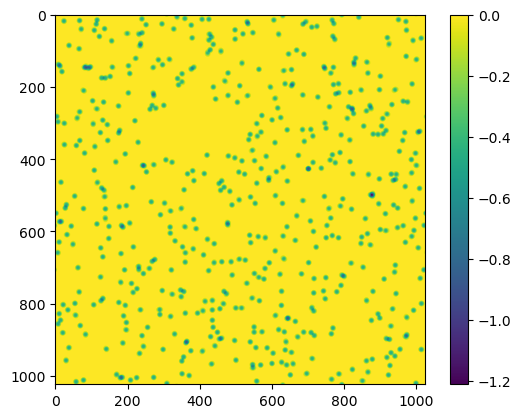

In [97]:
plt.imshow(file_content['arr_stack'][5])
plt.colorbar()

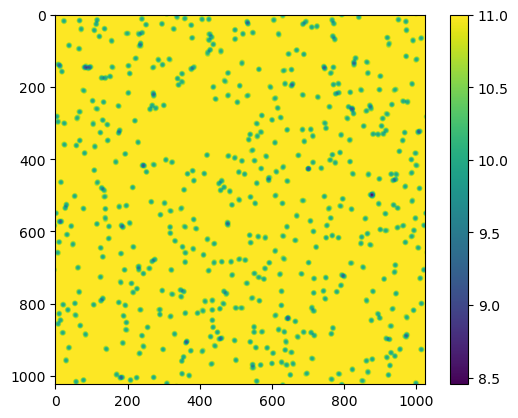

In [16]:
im = plt.imshow(np.abs(frame_sum))
plt.colorbar()